# Part 1
## 1.1 Data preparation

 1. Read data in - [1]
 2. Prepare Data - inside iterate function [8]
 
## 1.2 Regression
 3. Create and train the Random Forrest Regressor - [5]
 4. Create and train the MLP Regressor - [6]
 5. Create and train the SVM Regressor - [7]
 6.  Model can make predictions - [9]
## 1.3 Assessment
 1. Mean Absolute Error Calculation - [4]
 2. Cross validation [10]
 3. Box Plots [10]



## Packages needed:
- pandas
- sklearn
- numpy
- matplotlib
- tqdm

#### note: tqdm is only for the tracking of loop progress, if you don't want to install it, it can be removed and the code will function correctly without it. Just keep the range() inside

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use("fivethirtyeight")
BASE_DF = pd.read_csv("./AlgerianFF_Region1.csv")
BASE_DF.merge( pd.read_csv("./AlgerianFF_Region2.csv") )
options = ['Random Forrest', 'MLP', 'SVM']

# Pre-calculate the split point
SPLIT_POINT = math.floor( len(BASE_DF) * 0.7 ) # 70% train / 30% test


# Drop day and year as they will only confuse the AI
# Month is left in as the month could be a predicter of a forest fire
# From testing, dropping this does not decrease the best error, but does increase the worst.
BASE_DF = BASE_DF.drop( ["day", "year"] , axis=1 ) 
BASE_DF.head()

,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5


In [2]:
# Create a random sample of the base dataframe
def get_random_sample():
    return BASE_DF.sample(frac=1).reset_index(drop=True)

# Sanity check it gets a random stample
print( get_random_sample().head() )
print( get_random_sample().head() )


   month  Temperature   RH   Ws  Rain   FFMC   DMC    DC  ISI   BUI   FWI
0      7           31   68   14    0.0  85.4  12.1  43.1  4.6  14.2   6.0
1      6           31   55   16    0.1  79.9   4.5  16.0  2.5   5.3   1.4
2      6           33   50   14    0.0  88.7  22.9  92.8  7.2  28.3  12.9
3      7           33   68   19    0.0  85.6  12.5  49.8  6.0  15.4   8.0
4      7           33   78   17    0.0  80.1   4.6  18.5  2.7   5.7   1.7
   month  Temperature   RH   Ws  Rain   FFMC   DMC     DC  ISI   BUI   FWI
0      8           37   52   18    0.0  89.3  16.0  100.7  9.7  22.9  14.6
1      9           31   66   11    0.0  85.7   8.3   24.9  4.0   9.0   4.1
2      9           30   77   15    1.0  56.1   2.1    8.4  0.7   2.6   0.2
3      6           29   89   13    0.7  36.1   1.7    7.6  0.0   2.2   0.0
4      6           30   78   20    0.5  59.0   4.6    7.8  1.0   4.4   0.4


In [3]:
# Helper function to see the output of predictions
def print_predictions(regressor, X_test, y_test, limit=None):
    for i in range( len(X_test) ):
        print(f"Prediction: {regressor.predict([X_test[i]])[0]}\t\tActual: {y_test[i]}")
        if limit is not None and i == limit:
            break

# Calculate the mean absolute error
def calcMeanABSError(regressor, xs, ys):
    total = 0
    for i in range( len(xs) ):
        prediction = regressor.predict([xs[i]])[0]
        actual = ys[i]
        total += abs(prediction - actual)
    return total / len(xs)
    

In [4]:
def train_test_split(data, split_point):
    train, test = data[:split_point], data[split_point + 1: ]
    return [train, test]

In [5]:
from sklearn.ensemble import RandomForestRegressor
def train_RFR(X_train, y_train):
    return RandomForestRegressor().fit(X_train, y_train)

In [6]:
from sklearn.neural_network import MLPRegressor
def train_MLP(X_train, y_train):
    return MLPRegressor(max_iter=1500).fit(X_train, y_train)

In [7]:
from sklearn.svm import SVR
def train_SVR(X_train, y_train):
    return SVR().fit(X_train, y_train)

In [8]:
def iterate(df, results, index, print_outputs=False):

    # Targets is the FWI column
    y = np.array(df['FWI'])
    # Drop target (FWI) from training data

    # The dataframe has been randomly shuffled before being passed to this function
    #  As such, the data can only be prepared here as the targets (y) needs to be in the same order
    df = df.drop(['FWI'], axis=1) 
    inputs = np.array(df, float)

    X = preprocessing.scale(inputs) # Normalise inputs

    # Cross validation
    # As the df that is passed to this function is shuffled, all that is needed here is to create the train test split
    

    X_train, X_test = train_test_split(X, SPLIT_POINT)
    y_train, y_test = train_test_split(y, SPLIT_POINT)

    # Train all the regressors
    regressors = [
        train_RFR(X_train, y_train),
        train_MLP(X_train, y_train),
        train_SVR(X_train, y_train)
    ]

    if print_outputs:
        for i in range( len(regressors) ):
            print(options[i])
            print_predictions(regressors[i], X_test, y_test, limit=5)
            print("\n")
        return

    mae = []
    # For each regressor, calculate it's mean absolute error
    for regr in regressors:
        mae.append(
            calcMeanABSError(regr, X_test, y_test)
        )
        
    # Instead of returning the mae, they are added to a results dictionary
    # This is a thread safe dictionary provided by multiprocessing
    results[index] = mae

In [9]:
# Prove models can make predictions
iterate( get_random_sample(), 0, {}, print_outputs=True )

Random Forrest
Prediction: 0.09299999999999983		Actual: 0.0
Prediction: 0.9710000000000002		Actual: 0.7
Prediction: 7.063000000000003		Actual: 6.8
Prediction: 13.207		Actual: 14.6
Prediction: 13.123999999999993		Actual: 12.9
Prediction: 10.472000000000007		Actual: 13.2


MLP
Prediction: 0.2759868663527113		Actual: 0.0
Prediction: 0.9724390493487746		Actual: 0.7
Prediction: 6.519541466038447		Actual: 6.8
Prediction: 15.017779664593087		Actual: 14.6
Prediction: 12.794072395698427		Actual: 12.9
Prediction: 14.443349847944008		Actual: 13.2


SVM
Prediction: 0.6562337593640448		Actual: 0.0
Prediction: 2.5277327123256548		Actual: 0.7
Prediction: 6.147991801064448		Actual: 6.8
Prediction: 11.94308140508885		Actual: 14.6
Prediction: 11.265499480786254		Actual: 12.9
Prediction: 7.518111290826452		Actual: 13.2




100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


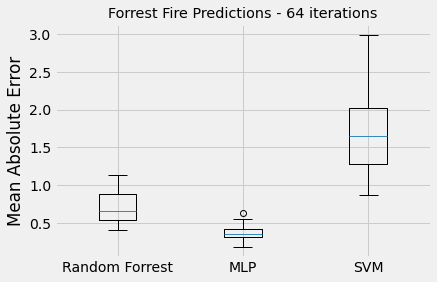

In [10]:
import multiprocessing
import tqdm

# Create the thread manager
manager = multiprocessing.Manager()

# This will hold all the jobs, to be awaited on
jobs = []


n_threads = 16 # Number of threads to run
ITERS= 64 # Nuber of iterations to run, better if it is divisable by n_threads

# Results
RFR_mae = []
MLP_mae = []
SVR_mae = []

# Basic threadding so I can do more cross validation faster
# Run in batches of n_threads
# Using tqdm to print the progress - it has no effect on the loop
# This loop cross validates the models.
# It is done by creating a new model with a randomly shuffled data-set
# and testing how good the model was. Results are put into a list and then graphed
for _ in tqdm.tqdm( range(0, ITERS, n_threads) ):
    results = manager.dict() # Create a thread safe dictionary

    # Create n_threads number of threads
    for i in range(n_threads):
        # Create a new worker thread that will process the iterate function
        # Pass it the a random sample of the dataframe, along with the thread safe result dictionary
        p = multiprocessing.Process(target=iterate, args=(get_random_sample(), results, i))
        jobs.append(p)
        p.start()
    for proc in jobs:
        # Await for all the threads to finish
        proc.join()
    # For all the results, extract the values 
    for result in results.values():
        RFR_mae.append(result[0])
        MLP_mae.append(result[1])
        SVR_mae.append(result[2])



# Graph the data
plt.boxplot([RFR_mae, MLP_mae, SVR_mae])
plt.style.use("ggplot")
plt.title(f"Forrest Fire Predictions - {ITERS} iterations")
plt.xticks([1, 2, 3], options)
plt.ylabel("Mean Absolute Error")
plt.show()
